In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
import shutil
import copy
from tqdm import tqdm
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/Users/mohameddiallo/Analyse-de-donnees-et-RL-inverse-pour-la-d-tection-de-biais/ProjetEmmanuelleClaeys/sex_classification'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

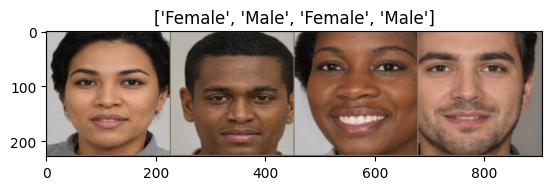

In [4]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Store losses and accuracies across epochs
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save losses and accuracies for plotting
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model, 'best_model_Gender_class.pth')  # Save the entire model

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)

    # Plot losses and accuracies
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(num_epochs), train_losses, label='Train')
    plt.plot(range(num_epochs), val_losses, label='Validation')
    plt.title('Loss across epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(num_epochs), train_accs, label='Train')
    plt.plot(range(num_epochs), val_accs, label='Validation')
    plt.title('Accuracy across epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model


In [7]:
model_ft = models.resnet101(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optimizer = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.95,nesterov=True) 

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch 0/34
----------
train Loss: 0.5458 Acc: 0.7176
val Loss: 0.2986 Acc: 0.8891

Epoch 1/34
----------
train Loss: 0.4235 Acc: 0.7939
val Loss: 0.2003 Acc: 0.9297

Epoch 2/34
----------
train Loss: 0.3959 Acc: 0.8181
val Loss: 0.2284 Acc: 0.9078

Epoch 3/34
----------
train Loss: 0.3828 Acc: 0.8359
val Loss: 0.1648 Acc: 0.9406

Epoch 4/34
----------
train Loss: 0.3880 Acc: 0.8244
val Loss: 0.1369 Acc: 0.9578

Epoch 5/34
----------
train Loss: 0.3324 Acc: 0.8511
val Loss: 0.1325 Acc: 0.9531

Epoch 6/34
----------
train Loss: 0.3120 Acc: 0.8639
val Loss: 0.1391 Acc: 0.9469

Epoch 7/34
----------
train Loss: 0.2806 Acc: 0.8906
val Loss: 0.1224 Acc: 0.9547

Epoch 8/34
----------
train Loss: 0.3377 Acc: 0.8588
val Loss: 0.1355 Acc: 0.9516

Epoch 9/34
----------
train Loss: 0.3150 Acc: 0.8626
val Loss: 0.1257 Acc: 0.9500

Epoch 10/34
----------
train Loss: 0.2741 Acc: 0.8753
val Loss: 0.1223 Acc: 0.9563

Epoch 11/34
----------
train Loss: 0.2697 Acc: 0.8969
val Loss: 0.1259 Acc: 0.9500

Ep

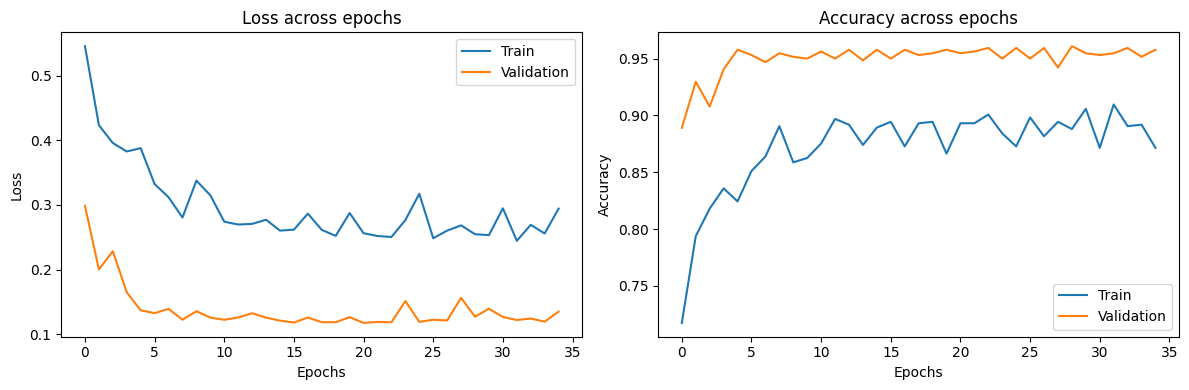

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=35)

In [9]:
# Charger le modèle PyTorch pré-entraîné
model = torch.load("best_model_Gender_class.pth")
model.eval()

# Vérifier le nombre de classes prédites par le modèle ResNet
num_classes = model.fc.out_features

print("Nombre de classes prédites par le modèle:", num_classes)

Nombre de classes prédites par le modèle: 2


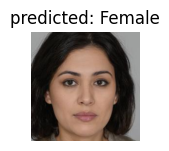

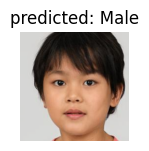

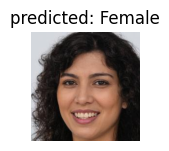

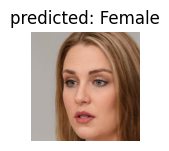

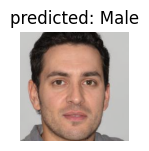

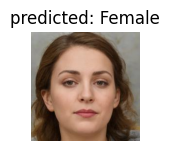

In [10]:
visualize_model(model_ft)

## Tester le modèle sur de nouvelles images

In [11]:
# Chemin des dossiers source et destination
source_dir = "/Users/mohameddiallo/Cours_de_deepLearning/ProjetEmmanuelleClaeys/Academic_Dataset_by_Generated_Photos/generated.photos"
train_dir = "/Users/mohameddiallo/Analyse-de-donnees-et-RL-inverse-pour-la-d-tection-de-biais/ProjetEmmanuelleClaeys/ALL-data_sex_traning"
new_images_dir = "/Users/mohameddiallo/Analyse-de-donnees-et-RL-inverse-pour-la-d-tection-de-biais/ProjetEmmanuelleClaeys/Predict_Gender"

# Charger le modèle PyTorch pré-entraîné
model = torch.load("best_model_Gender_class.pth")
model.eval()

# Transformation des images pour l'inférence
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


# Fonction pour tester le modèle sur les nouvelles images
def classify_new_images(source_dir, train_dir, new_images_dir, model):
    since = time.time()
    # Liste des fichiers dans le dossier source
    source_files = [f for f in os.listdir(source_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
    
    # Liste des fichiers dans le dossier d'entraînement
    train_files = os.listdir(train_dir)
    
    # Création d'un nouveau dossier pour les nouvelles images
    if not os.path.exists(new_images_dir):
        os.makedirs(new_images_dir)
    
    # Comparaison des fichiers
    for file in tqdm(source_files,desc="Prédiction de nouveaux images", unit="image"):
        if file not in train_files:
            # Copie des nouvelles images dans le nouveau dossier
            shutil.copy(os.path.join(source_dir, file), os.path.join(new_images_dir, file))
            
            # Charger l'image et effectuer la prédiction
            image = Image.open(os.path.join(new_images_dir, file))
            image = transform(image).unsqueeze(0)
            output = model(image)
            _, predicted = torch.max(output, 1)
            
            # Créer un sous-dossier pour la classe prédite si nécessaire
            predicted_class_dir = os.path.join(new_images_dir, str(predicted.item()))
            if not os.path.exists(predicted_class_dir):
                os.makedirs(predicted_class_dir)
            
            # Déplacer l'image dans le sous-dossier de la classe prédite
            shutil.move(os.path.join(new_images_dir, file), os.path.join(predicted_class_dir, file))
            
    time_elapsed = time.time() - since
    print(f'Classification complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
# Appel de la fonction
classify_new_images(source_dir, train_dir, new_images_dir, model)

Prédiction de nouveaux images: 100%|███| 10000/10000 [33:47<00:00,  4.93image/s]


Classification complete in 33m 48s
